In [62]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, shifted_f, shifted_e, chirp2total, total2chirp, overlap_cplx_wfs, get_h
from scipy.stats import mode

In [11]:
# Calculates match over range of intial frequency values
def s_f_quad_match(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, h_ap, h_peri = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []
    s_f_matches_ap = []
    s_f_matches_peri = []
    wf_lens = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)
        wf_lens.append(len(s))

        # Matches against h1
        match = overlap_cplx_wfs(h1, s, f_low)
        s_f_matches_1.append(abs(match))
        # Matches against h2
        match = overlap_cplx_wfs(h2, s, f_low)
        s_f_matches_2.append(abs(match))
        # # Matches against h_ap
        # match = overlap_cplx_wfs(h_ap, s, f_low)
        # s_f_matches_ap.append(abs(match))
        # # Matches against h_peri
        # match = overlap_cplx_wfs(h_peri, s, f_low)
        # s_f_matches_peri.append(abs(match))
    
        # Calculate total quad match of h1 and h2
        s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Saves data
    data['h_ap'] = s_f_matches_ap
    data['h_peri'] = s_f_matches_peri
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['h_quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals
    data['wf_lens'] = wf_lens

    return data

In [73]:
# Makes plot of quad match data
def plot_s_f_quad_match(fiducials, e_M, data, f_low, approximant='TEOBResumS', xlims=None, ylims=(0.9,1.01), len_diff_test=False):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='dashed', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h2'], ls='dotted', c=f'C0', label=f'h2 $e={e}$, $M={M}~M_\odot$')
    #ax1.plot(data['s_f_vals'], data['h_ap'], ls='dashdot', c=f'C0', label=f'h_ap $e={e}$, $M={M}~M_\odot$')
    #ax1.plot(data['s_f_vals'], data['h_peri'], ls=(5, (10, 3)), c=f'C0', label=f'h_peri $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h_quad'], ls='solid', c=f'C0', label=f'quad $e={e}$, $M={M}~M_\odot$')
    ax1.scatter(data['s_f_vals'], data['h_quad'], ls='solid', c='k', marker='x', label=f'quad $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')

    # Plot vertical lines where difference in waveform lengths is different to normal
    print(np.unique(np.diff(data['wf_lens'])))
    if len_diff_test:
        for i in range(len(data['wf_lens'])-1):
            if data['wf_lens'][i+1] - data['wf_lens'][i] != mode(np.diff(data['wf_lens']))[0]:
                ax1.axvline(data['s_f_vals'][i+1], c='r')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_xlim(xlims)
    ax1.set_ylim(ylims)

In [12]:
start = time.time()
sample_rate = 4096
dataslot_0 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 201, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

201 done out of 201
Time taken: 323.75441551208496 seconds


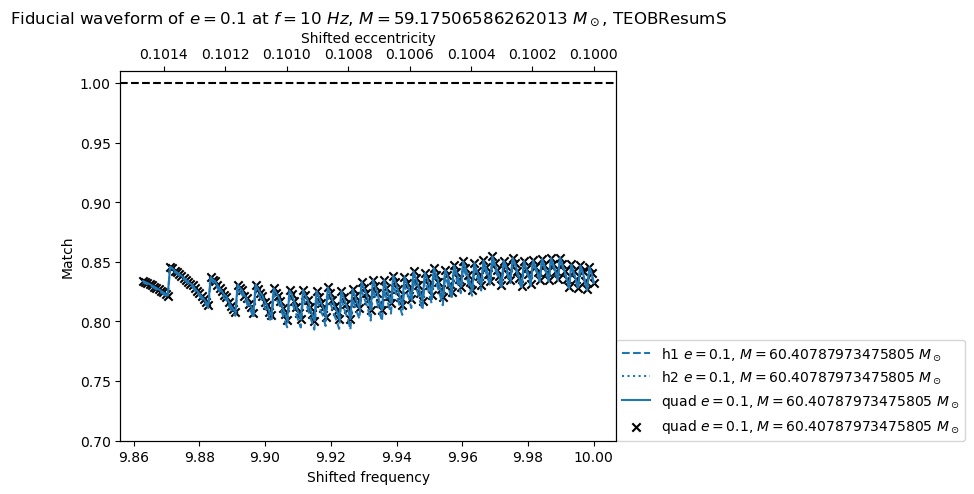

In [22]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_0, 10, ylims=(0.7,1.01))

[4 5]


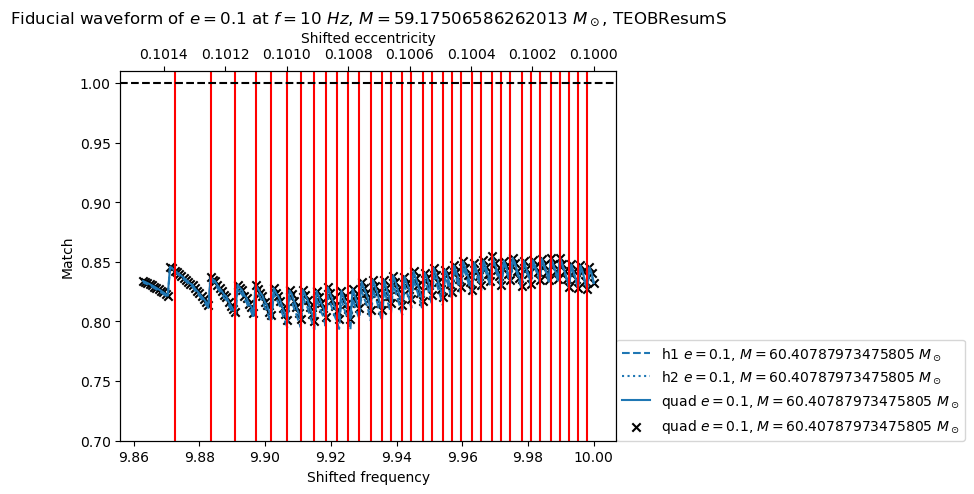

In [74]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_0, 10, xlims=None, ylims=(0.7,1.01), len_diff_test=True)

In [23]:
start = time.time()
sample_rate = 4096
dataslot_1 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), 201, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

201 done out of 201
Time taken: 337.13554310798645 seconds


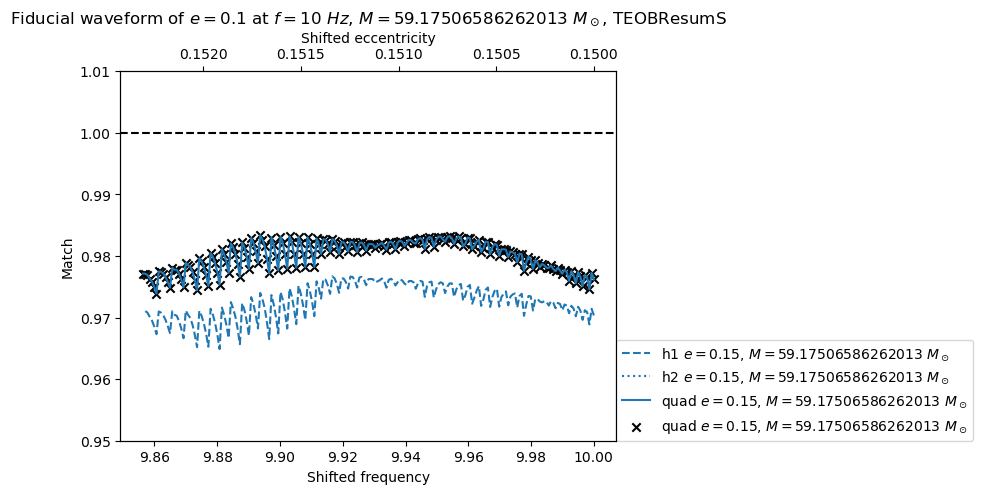

In [31]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_1, 10, ylims=(0.95,1.01))

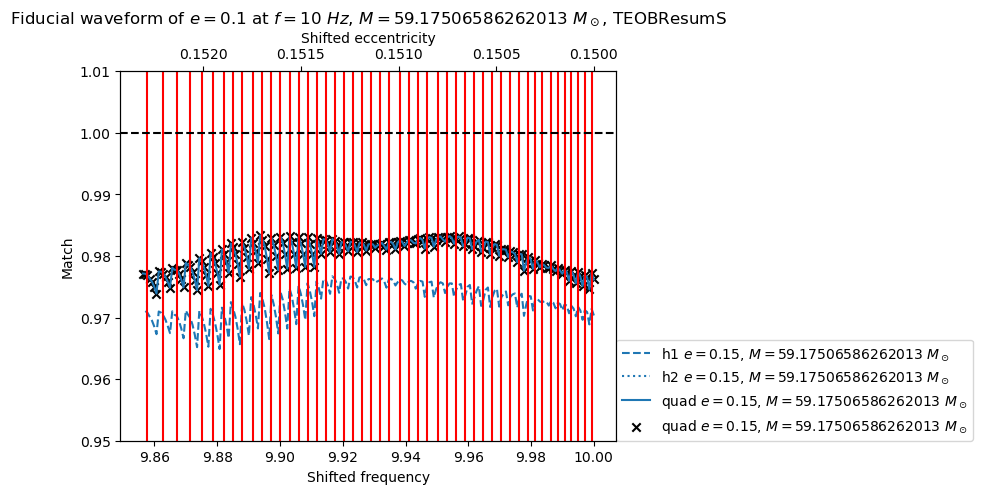

In [61]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_1, 10, xlims=None, ylims=(0.95,1.01), len_diff_test=True)

In [35]:
start = time.time()
sample_rate = 4096
dataslot_2 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24.25, 2)), 201, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

201 done out of 201
Time taken: 332.98800468444824 seconds


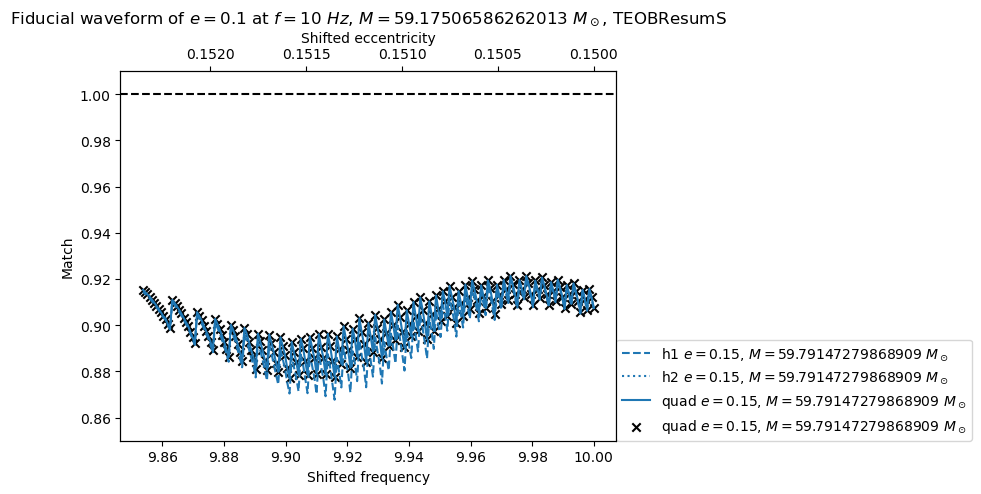

In [39]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24.25, 2)), dataslot_2, 10, ylims=(0.85,1.01))

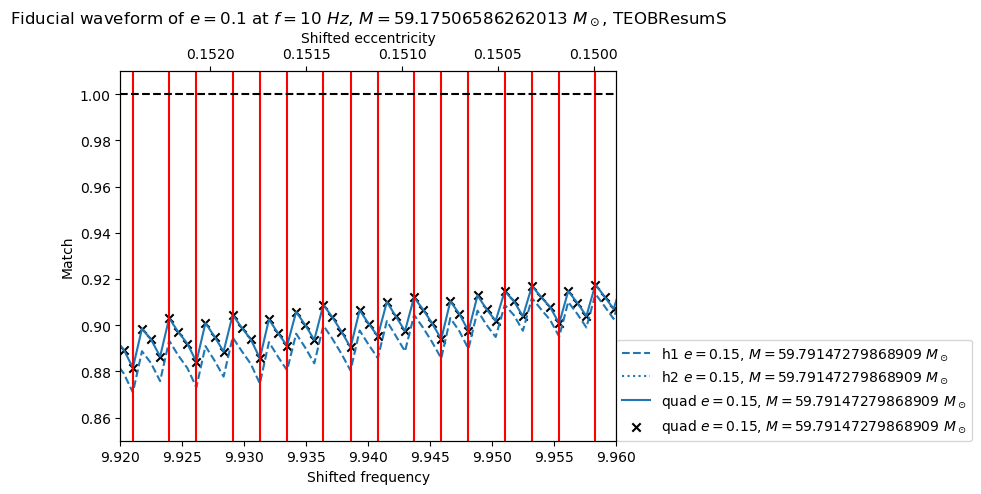

In [55]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24.25, 2)), dataslot_2, 10, xlims=(9.92, 9.96), ylims=(0.85,1.01), len_diff_test=True)

# Increasing sample rate

In [56]:
start = time.time()
sample_rate = 16384
dataslot_3 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 201, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

201 done out of 201
Time taken: 438.85512709617615 seconds


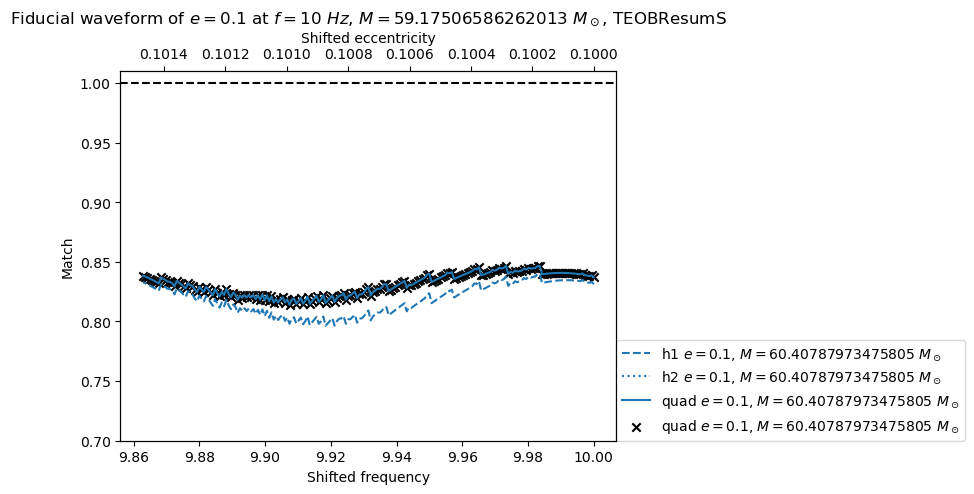

In [57]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_3, 10, ylims=(0.7,1.01))

[19 20]


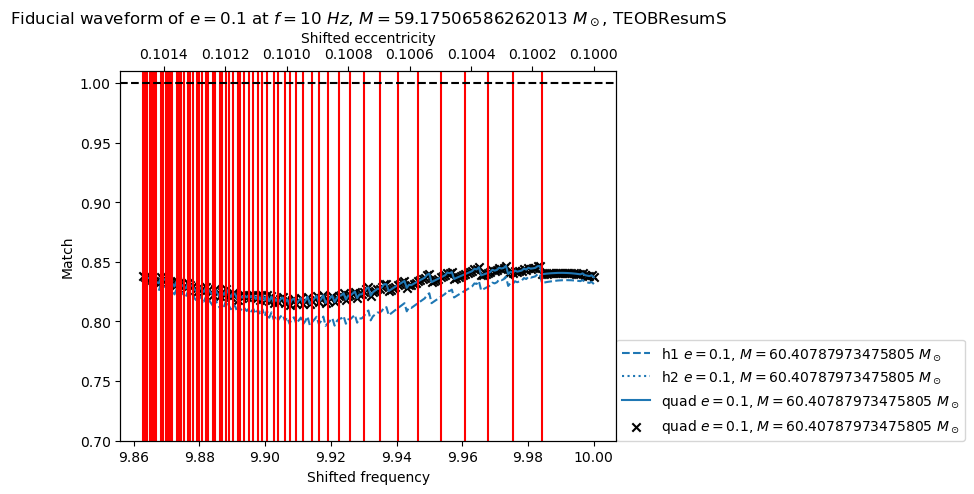

In [79]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_3, 10, xlims=None, ylims=(0.7,1.01), len_diff_test=True)